In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import Dense

from datetime import datetime

In [2]:
def assessment(f_data, f_y_feature, f_x_feature, f_index=-1):

    for f_row in f_data:
        if f_index >= 0:
            f_color = np.where(f_data[f_row].index == f_index,'r','g')
            f_hue = None
        else:
            f_color = 'b'
            f_hue = None
    
    f_fig, f_a = plt.subplots(1, 2, figsize=(16,4))
    
    f_chart1 = sns.distplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='g')
    f_chart1.set_xlabel(f_x_feature,fontsize=10)
    
    if f_index >= 0:
        f_chart2 = plt.scatter(f_data[f_x_feature], f_data[f_y_feature], c=f_color, edgecolors='w')
        f_chart2 = plt.xlabel(f_x_feature, fontsize=10)
        f_chart2 = plt.ylabel(f_y_feature, fontsize=10)
    else:
        f_chart2 = sns.scatterplot(x=f_x_feature, y=f_y_feature, data=f_data, hue=f_hue, legend=False)
        f_chart2.set_xlabel(f_x_feature,fontsize=10)
        f_chart2.set_ylabel(f_y_feature,fontsize=10)

    plt.show()

    
def correlation_map(f_data, f_feature, f_number):
   
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    with sns.axes_style("white"):
        f_fig, f_ax = plt.subplots(figsize=(20, 10))
        sns.heatmap(f_correlation, mask=f_mask, vmin=-1, vmax=1, square=True,
                    center=0, annot=True, annot_kws={"size": 8}, cmap="PRGn")
    plt.show()

In [3]:
sns.set()
start_time = datetime.now()

data = pd.read_csv('smart_grid_stability_augmented.csv')

map1 = {'unstable': 0, 'stable': 1}
data['stabf'] = data['stabf'].replace(map1)

data = data.sample(frac=1)

In [4]:
data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
47453,8.047352,2.167273,3.086424,6.459783,4.205943,-1.927072,-0.969859,-1.309013,0.626860,0.205403,0.332150,0.881761,0.036425,0
18216,4.881537,8.826495,0.672398,4.460787,3.721356,-1.491083,-0.648768,-1.581505,0.700856,0.853181,0.077609,0.855622,0.052661,0
5438,9.032898,1.865521,1.382852,0.647375,4.088996,-0.838429,-1.613545,-1.637023,0.333489,0.306194,0.812345,0.871778,-0.033881,1
41186,1.500072,9.164578,5.466607,2.318360,2.492276,-0.690842,-0.834243,-0.967192,0.190649,0.635479,0.344544,0.992743,-0.003320,1
21766,0.721472,7.852192,5.495173,2.519541,5.169904,-1.946333,-1.667228,-1.556343,0.358372,0.980840,0.452532,0.328424,0.014923,0


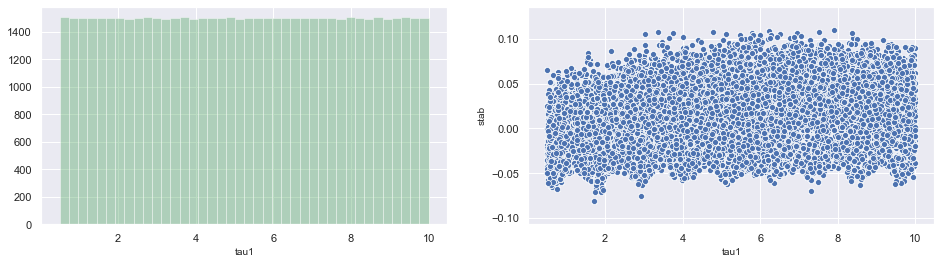

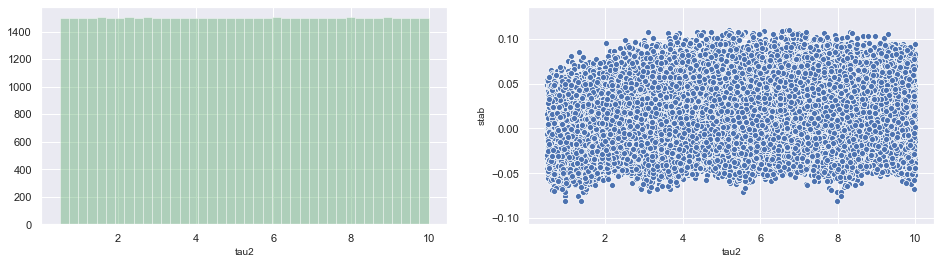

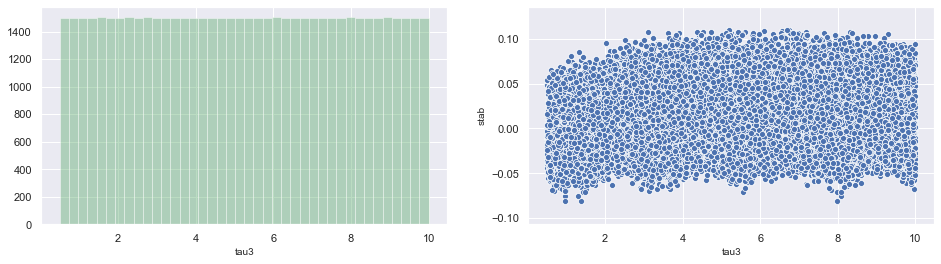

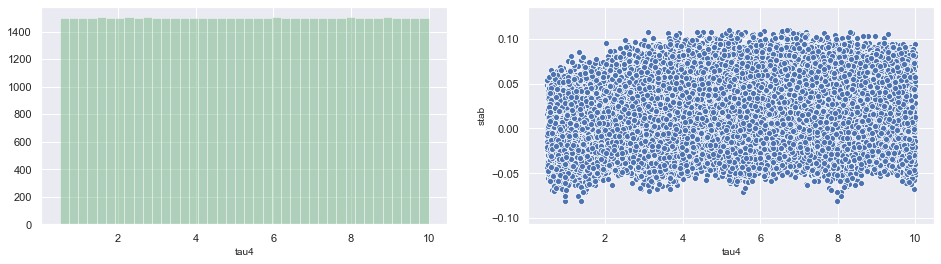

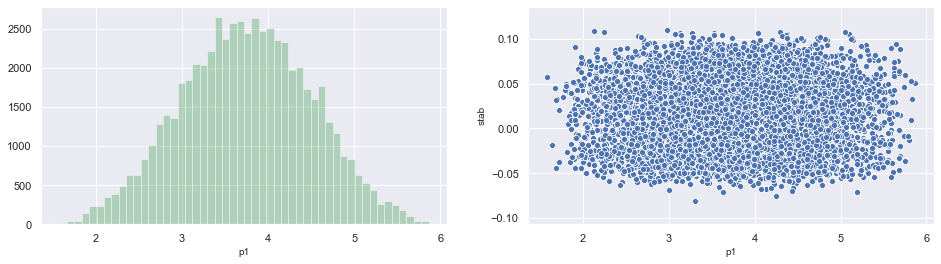

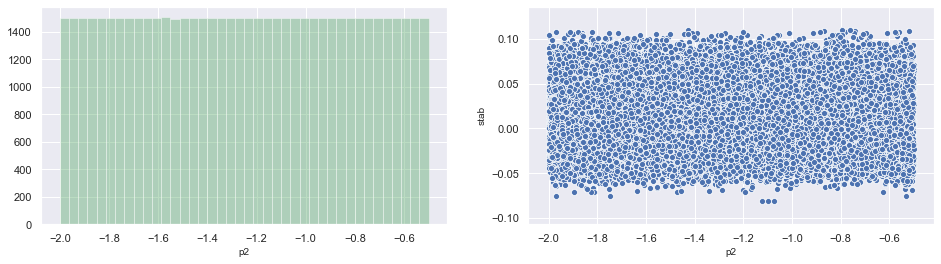

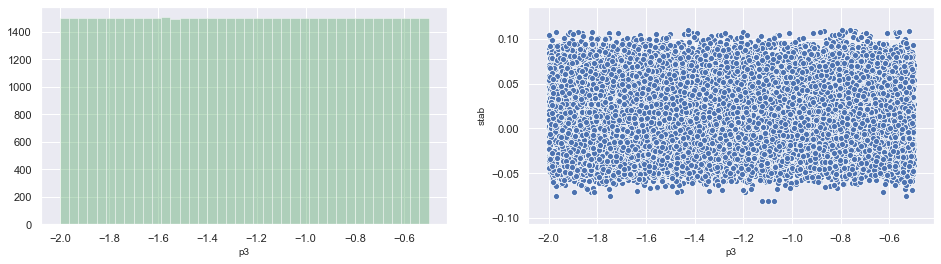

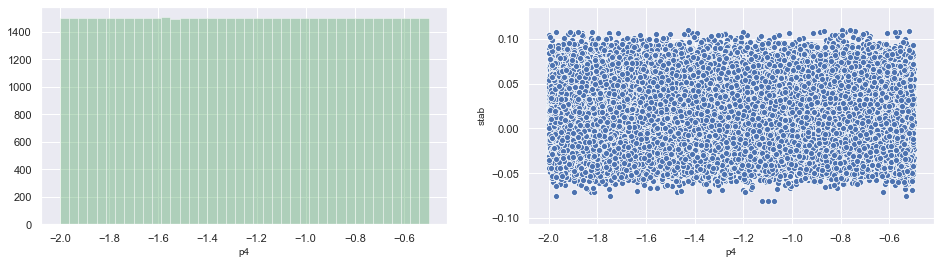

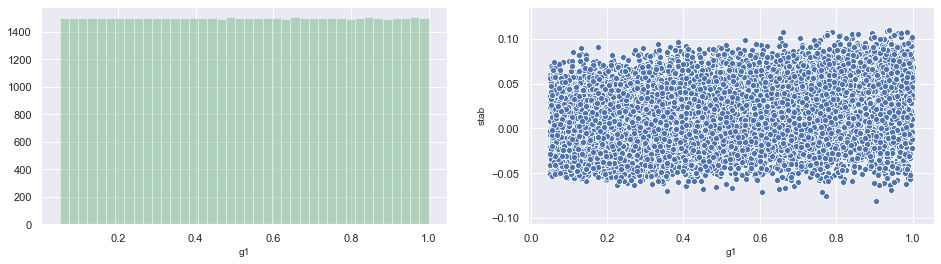

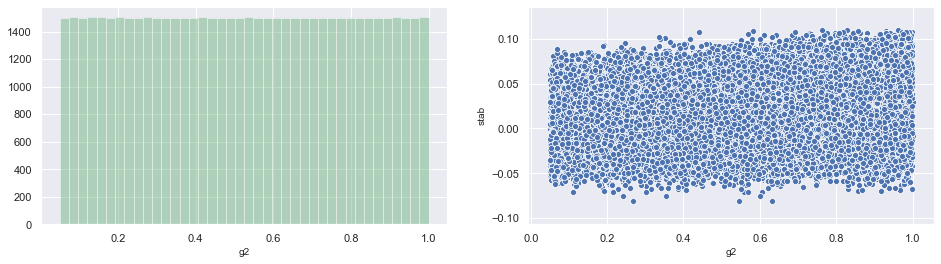

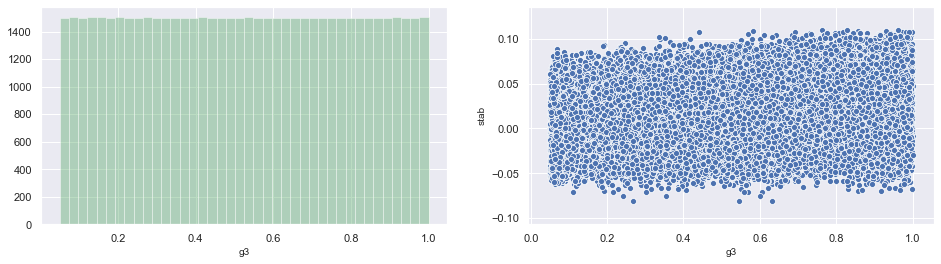

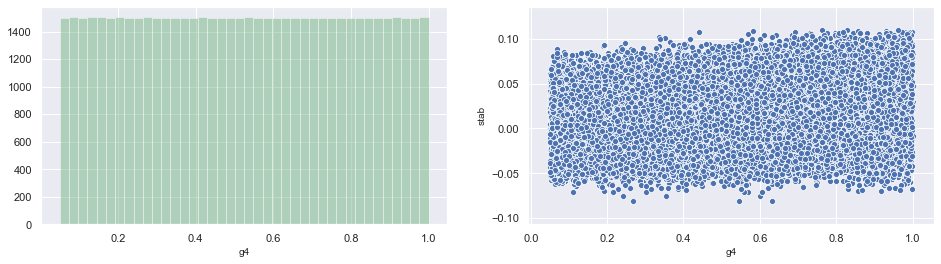

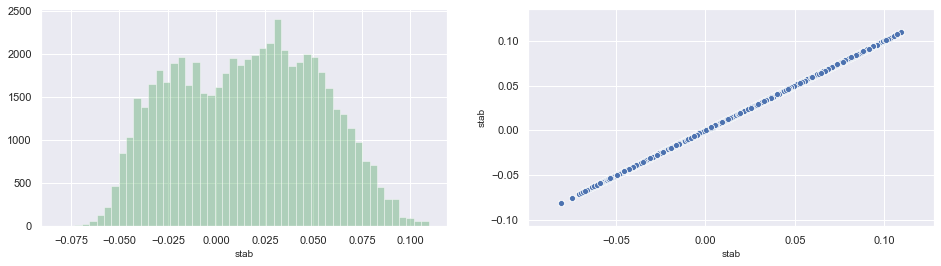

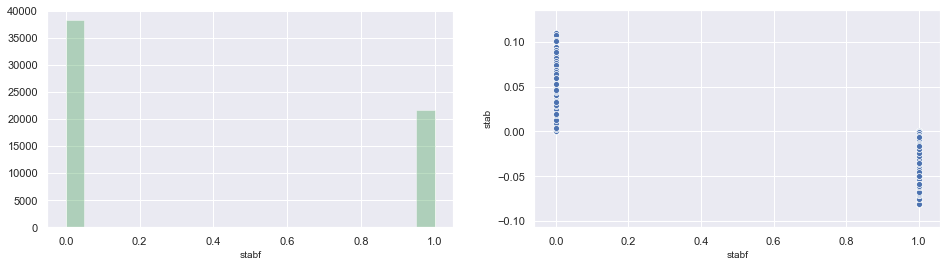

In [5]:
for column in data.columns:
    assessment(data, 'stab', column, -1)

In [6]:
data.p1.skew()

-0.012688423269883488

In [7]:
print(f'Split of "unstable" (0) and "stable" (1) observations in the original dataset:')
print(data['stabf'].value_counts(normalize=True))

Split of "unstable" (0) and "stable" (1) observations in the original dataset:
0    0.638
1    0.362
Name: stabf, dtype: float64


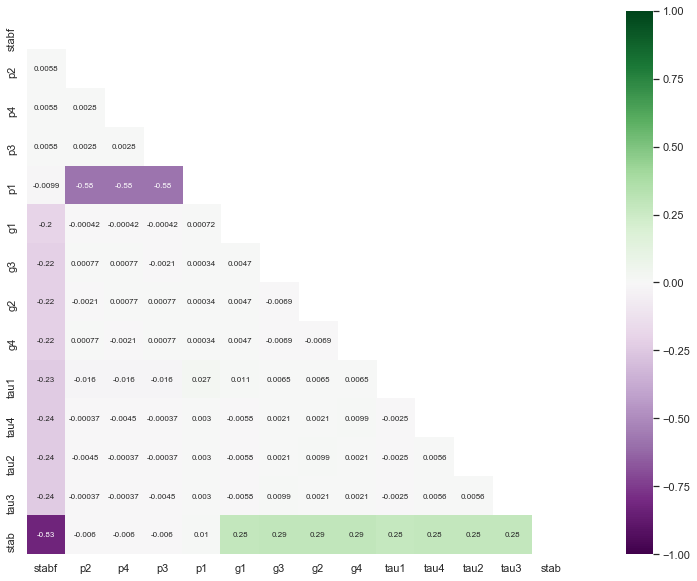

In [8]:
correlation_map(data, 'stabf', 14)

In [9]:
X = data.iloc[:, :12]
y = data.iloc[:, 13]

X_training = X.iloc[:54000, :]
y_training = y.iloc[:54000]

X_testing = X.iloc[54000:, :]
y_testing = y.iloc[54000:]

ratio_training = y_training.value_counts(normalize=True)
ratio_testing = y_testing.value_counts(normalize=True)
ratio_training, ratio_testing

(0    0.637926
 1    0.362074
 Name: stabf, dtype: float64,
 0    0.638667
 1    0.361333
 Name: stabf, dtype: float64)

In [10]:
X_training = X_training.values
y_training = y_training.values

X_testing = X_testing.values
y_testing = y_testing.values

In [11]:
scaler = StandardScaler()
X_training = scaler.fit_transform(X_training)
X_testing = scaler.transform(X_testing)

In [12]:
classifier = Sequential()

# Input layer and first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))

# Second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Third hidden layer
classifier.add(Dense(units = 12, kernel_initializer = 'uniform', activation = 'relu'))

# Single-node output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# ANN compilation
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [13]:
cross_val_round = 1
print(f'Model evaluation\n')

for train_index, val_index in KFold(10, shuffle=True, random_state=10).split(X_training):
    x_train, x_val = X_training[train_index], X_training[val_index]
    y_train ,y_val = y_training[train_index], y_training[val_index]
    classifier.fit(x_train, y_train, epochs=50, verbose=0)
    classifier_loss, classifier_accuracy = classifier.evaluate(x_val, y_val)
    print(f'Round {cross_val_round} - Loss: {classifier_loss:.4f} | Accuracy: {classifier_accuracy * 100:.2f} %')
    cross_val_round += 1

Model evaluation

169/169 [==============================] - 0s 696us/step - loss: 0.0969 - accuracy: 0.9585
Round 1 - Loss: 0.0969 | Accuracy: 95.85 %
169/169 [==============================] - 0s 608us/step - loss: 0.0627 - accuracy: 0.9724
Round 2 - Loss: 0.0627 | Accuracy: 97.24 %
169/169 [==============================] - 0s 575us/step - loss: 0.0535 - accuracy: 0.9769
Round 3 - Loss: 0.0535 | Accuracy: 97.69 %
169/169 [==============================] - 0s 547us/step - loss: 0.0471 - accuracy: 0.9804
Round 4 - Loss: 0.0471 | Accuracy: 98.04 %
169/169 [==============================] - 0s 644us/step - loss: 0.0501 - accuracy: 0.9815
Round 5 - Loss: 0.0501 | Accuracy: 98.15 %
169/169 [==============================] - 0s 557us/step - loss: 0.0386 - accuracy: 0.9843
Round 6 - Loss: 0.0386 | Accuracy: 98.43 %
169/169 [==============================] - 0s 624us/step - loss: 0.0356 - accuracy: 0.9863
Round 7 - Loss: 0.0356 | Accuracy: 98.63 %
169/169 [==============================] - 0

In [14]:
y_pred = classifier.predict(X_testing)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [15]:
cm = pd.DataFrame(data=confusion_matrix(y_testing, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,3765,67
Actual Stable,60,2108


In [16]:
print(f'Accuracy per the confusion matrix: {((cm.iloc[0, 0] + cm.iloc[1, 1]) / len(y_testing) * 100):.2f}%')

Accuracy per the confusion matrix: 97.88%
